# Notebook to Compare SWE DataSources 

# Step 0 - Set Up Notebook

In [1]:
# import libraries 
import pandas as pd
import geopandas as gpd
import numpy as np
import fsspec
import warnings
import geopandas as gpd
import xarray as xr
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import get_dem as dm
from snowML.datapipe.utils import data_utils as du


In [2]:
# define constants/urls/filenames
cedar_dict = {
    "url": "https://data.cig.uw.edu/picea/mauger/misc/wrf_run_agg/Aggregated.Values_Cedar",
    "hsvm_shape_key": "hsvm_cedar.geojson",
    "hsvm_huc_key": "hucs_match_hsvm_cedar.geojson", 
    "UCLA_file_nm": "mean_swe_ucla_2_in_Cedar.csv"
}


In [3]:
# common begin and end dates for filtering 
BEGIN_DATE = '1984-10-01T00:00:00.000000000'
END_DATE = " 2020-12-31T00:00:00.000000000"

In [4]:
# Step 1 Define Functions 

In [5]:
def load_hsvm_data(url): 
    tem = pd.read_csv(url, sep = '\\s+' )
    tem.set_index(pd.DatetimeIndex(tem.iloc[:, 0]), inplace = True)
    return tem

In [6]:
def load_shape(key):
    s3_url = f's3://snowml-shape/{key}'
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        gdf = gpd.read_file(f"s3://snowml-shape/{key}", storage_options={'anon': False}) 
    return gdf


In [7]:
def prep_UA_bronze_swe():
    b_bronze = "snowml-bronze"
    zarr_store_url = f's3://{b_bronze}/swe_all.zarr'

    # Open the Zarr file directly with storage options
    ds = xr.open_zarr(zarr_store_url, consolidated=True, storage_options={'anon': False})
    #print("Opened Zarr file successfully.")
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("EPSG:4326", inplace=True)
    return ds

In [8]:
def mask_swe(ds, mask):
    crs = ds.rio.crs
    ds_small = ds.rio.clip(mask.geometry, crs, drop=True, invert=False)
    if not ds_small['day'].to_index().is_monotonic_increasing:
        ds_small = ds_small.sortby("day")
    return ds_small



In [9]:
def mean_swe_UA_from_shape(gdf):
    ds = prep_UA_bronze_swe()
    ds_small = mask_swe(ds, gdf)
    mean_swe = ds_small["SWE"].mean(dim=["lat", "lon"])
    df_mean_swe = mean_swe.to_dataframe(name="mean_swe").reset_index()
    df_mean_swe["day"] = pd.to_datetime(df_mean_swe["day"])
    df_mean_swe = df_mean_swe.set_index("day")
    df_mean_swe = df_mean_swe[["mean_swe"]] # drop crs column 
    return df_mean_swe
    

In [10]:
def tot_swe_one_huc(huc): 
    b = "snowml-gold"
    geos = gg.get_geos_with_name(huc, '12')
    geos_proj = geos.to_crs(epsg=26910)
    area = geos_proj.geometry.iloc[0].area  # area in square meters
    f = f"mean_swe_in_{huc}.csv"
    df = du.s3_to_df(f, b)
    df = df.set_index("day")
    df["total_swe"] = df["mean_swe"]*area # multiply by area; adjust units 
    return df[["total_swe"]], area 
    

In [11]:
def mean_swe_from_hucs(huc_list): 
    df, area = tot_swe_one_huc(huc_list[0])
    tot_area = area 
    df_all = df
    for huc in huc_list[1:]:
        #print(f"Processing huc {huc}")
        df, area = tot_swe_one_huc(huc)
        tot_area += area
        df_all["total_swe"] = df_all["total_swe"] + df["total_swe"] 
    df_all["mean_swe"] = df_all["total_swe"]/tot_area
    return df_all
        

In [12]:
def filter_by_date(df, begin_date, end_date):
    # Ensure the index is datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Convert input dates to datetime
    begin_date = pd.to_datetime(begin_date)
    end_date = pd.to_datetime(end_date)

    # Filter using boolean indexing
    return df[(df.index >= begin_date) & (df.index <= end_date)]


In [13]:
def plot(x_vals, y_dict_list, ttl = "Mean Swe Various Sources"): 
    # Ensure x values are datetime
    x_vals = pd.to_datetime(x_vals)
    
    plt.figure(figsize=(12, 6))
    for plot_dict in y_dict_list:
        plt.plot(
            x_vals,
            plot_dict["y_vals"],
            c=plot_dict["color"],
            label=plot_dict["label"]
            )
                
    plt.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('SWE')
    plt.title(ttl)

    # Format x-axis to show only the year
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.show()

In [14]:
def similarity(df_dict):
    """
    Computes R-squared, Pearson correlation, alpha, and beta between 'mean_swe' columns 
    for each pair of DataFrames in df_dict.

    Parameters:
    df_dict (dict): Dictionary where keys are identifiers and values are DataFrames
                    with a 'mean_swe' column.
    """
    keys = list(df_dict.keys())
    results = []

    for key1, key2 in itertools.combinations(keys, 2):
        df1 = df_dict[key1]
        df2 = df_dict[key2]

        # Align on index (e.g., day)
        df1_aligned, df2_aligned = df1.align(df2, join='inner')

        a = df1_aligned['mean_swe']
        b = df2_aligned['mean_swe']

        r2 = r2_score(a, b)
        pearson_corr, _ = pearsonr(a, b)
        alpha = np.std(a) / np.std(b) if np.std(b) != 0 else np.nan
        beta = np.mean(a) / np.mean(b) if np.mean(b) != 0 else np.nan

        results.append((key1, key2, pearson_corr, alpha, beta, r2))

    # Create and print a clean DataFrame of results
    results_df = pd.DataFrame(
        results, 
        columns=['Dataset 1', 'Dataset 2', 'Pearson Corr', 'Ratio_var', 'Ratio_means', 'R-squared']
    )
    print(results_df.round(3))


# Step 2 - Load and Visualize HSVM SWE 

In [32]:
my_dict = cedar_dict

In [36]:
# get mean swe from hsvm model output 
def calc_and_plot_hsvm(my_dict):
    hsvm_model = load_hsvm_data(my_dict["url"])
    hsvm_swe = hsvm_model[["Swq"]]
    daily_mean_df = hsvm_swe.resample('D').mean()
    daily_mean_df.rename(columns={"Swq": "mean_swe"}, inplace=True)
    daily_mean_df = filter_by_date(daily_mean_df, BEGIN_DATE, END_DATE)
    x_vals = daily_mean_df.index.values
    HSVM_dict = {
        "y_vals": daily_mean_df["mean_swe"], 
        "label": "hsvm_model", 
        "color": "red"
    }
    plot(x_vals, [HSVM_dict], ttl = "Mean Swe HSVM")
    return x_vals, daily_mean_df, HSVM_dict


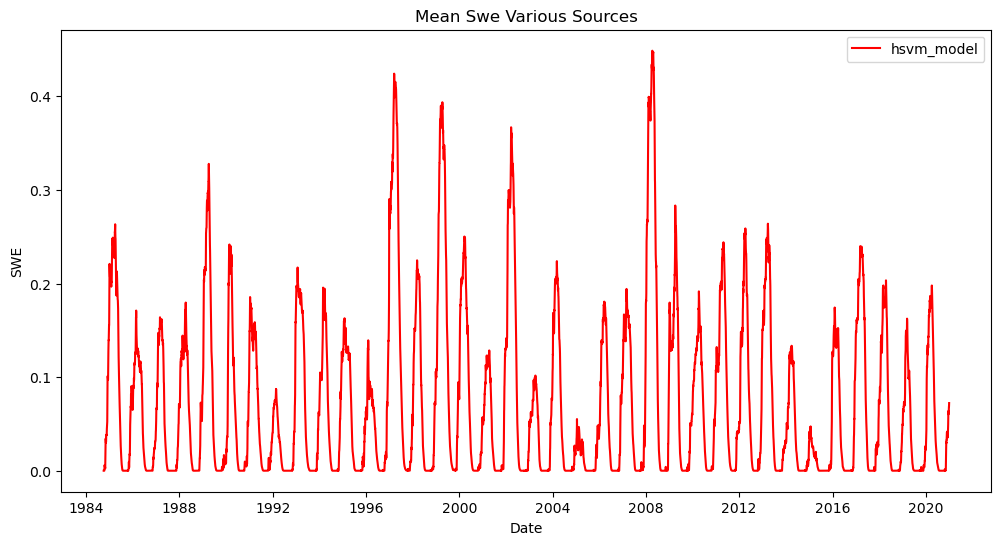

In [37]:
x_vals, daily_mean_df, HSVM_dict = calc_and_plot_hsvm(my_dict)

# Step 4 - Load and Visualize UA SWE 

In [43]:
def calc_UA(my_dict): 
    geos_hsvm = load_shape(my_dict["hsvm_shape_key"])
    df_UA_all = mean_swe_UA_from_shape(geos_hsvm) 
    df_UA_all = filter_by_date(df_UA_all, BEGIN_DATE, END_DATE)
    df_UA_all["mean_swe"] = df_UA_all["mean_swe"]/1000
    x_vals = df_UA_all.index.values
    df_UA_all_dict = {
        "y_vals": df_UA_all["mean_swe"],
        "label": "UA",
        "color": "blue"
    }
    return df_UA_all, df_UA_all_dict 

def calc_UA_from_huc(my_dict): 
    # get UA mean Swe by aggregating over Hucs 
    geos_hsvm_hucs = load_shape(my_dict["hsvm_huc_key"])
    huc_list= geos_hsvm_hucs["huc_id"]
    df_UA_from_hucs = mean_swe_from_hucs(huc_list)
    df_UA_from_hucs = filter_by_date(df_UA_from_hucs, BEGIN_DATE, END_DATE)
    df_UA_from_hucs["mean_swe"] = df_UA_from_hucs["mean_swe"]/1000
    df_UA_hucs_dict = {
        "y_vals": df_UA_from_hucs["mean_swe"],
        "label": "UA_calc_from_hucs",
        "color": "purple"
    }

    return df_UA_from_hucs, df_UA_hucs_dict


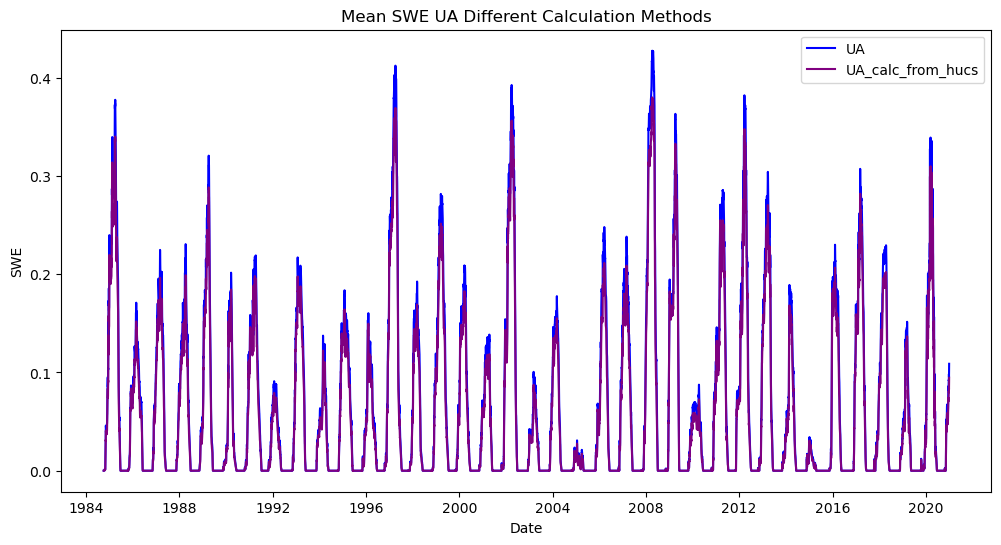

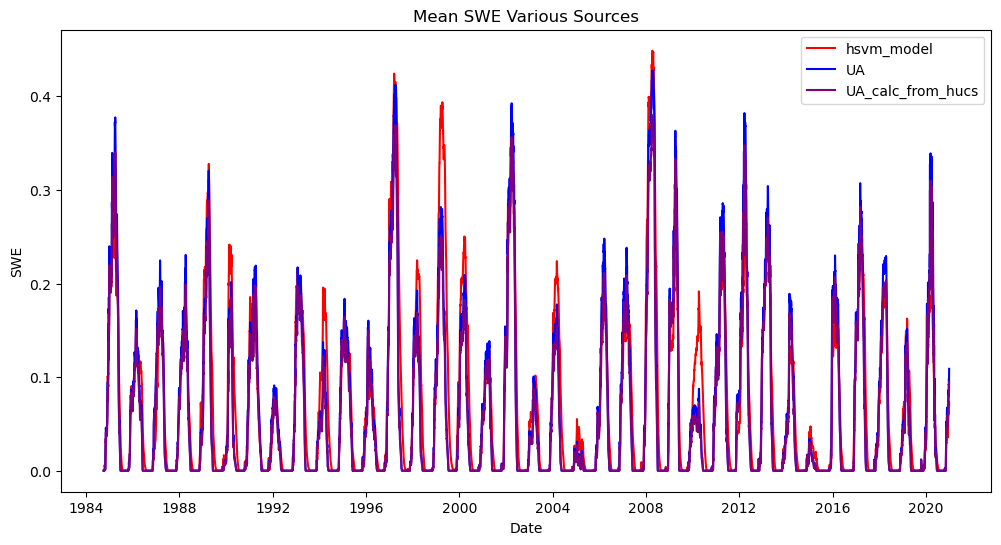

In [46]:
df_UA_all, df_UA_all_dict =  calc_UA(my_dict)
df_UA_from_hucs, df_UA_hucs_dict = calc_UA_from_huc(my_dict)
plot(x_vals, [df_UA_all_dict, df_UA_hucs_dict], ttl = "Mean SWE UA Different Calculation Methods")
plot(x_vals, [HSVM_dict, df_UA_all_dict, df_UA_hucs_dict], ttl = "Mean SWE Various Sources")

In [24]:
# Step 5 - Load and Visualize UCLA data 

In [48]:
def calc_UCLA(my_dict): 
    f = my_dict["UCLA_file_nm"]
    b = "snowml-gold"
    df_UCLA = du.s3_to_df(f, b)
    df_UCLA = df_UCLA.set_index("day")
    df_UCLA.rename(columns={"SWE_Post": "mean_swe"}, inplace=True)
    df_UCLA = filter_by_date(df_UCLA, BEGIN_DATE, END_DATE)
    #df_UCLA.head(2)
    df_UCLA_dict = {
        "y_vals": df_UCLA["mean_swe"],
        "label": "UCLA",
        "color": "black"
    }
    return df_UCLA, df_UCLA_dict

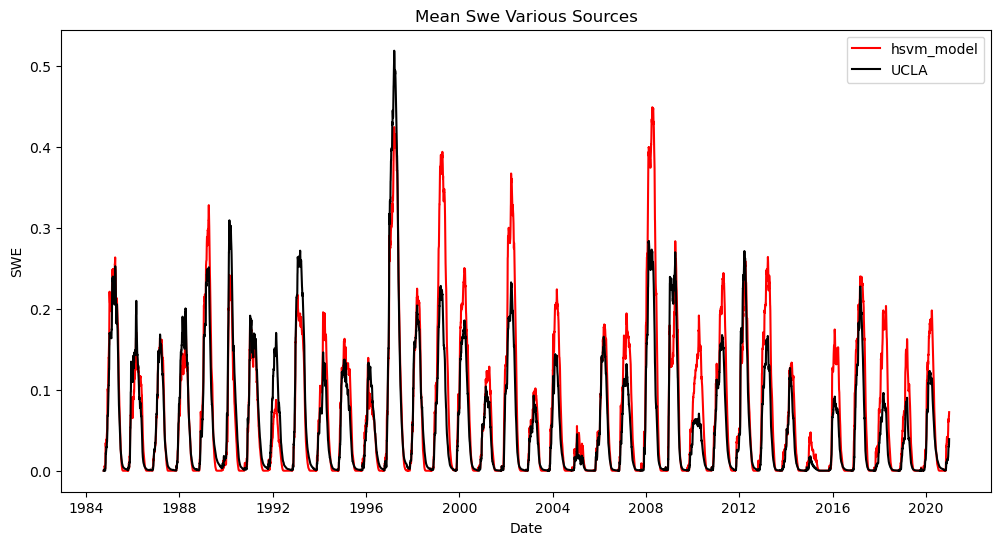

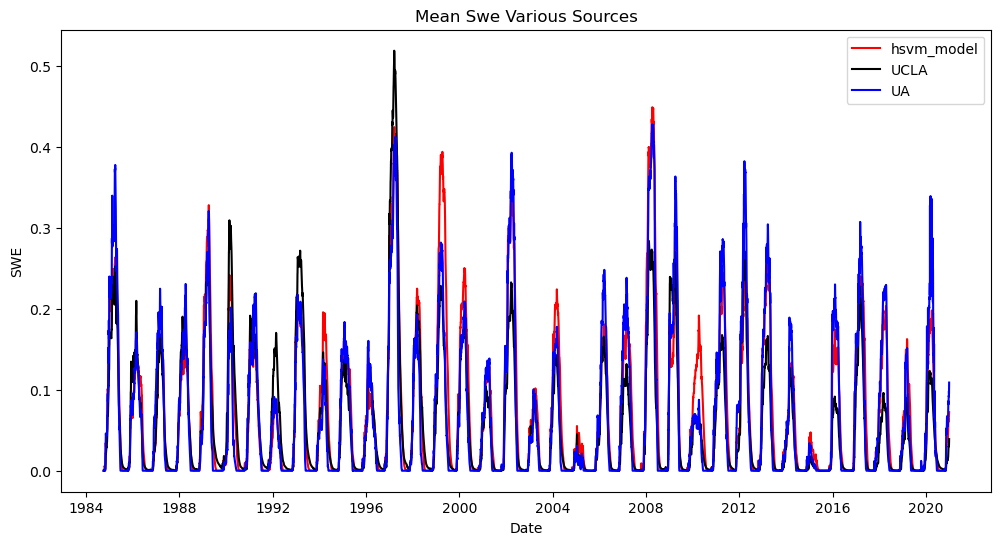

In [49]:
df_UCLA, df_UCLA_dict =  calc_UCLA(my_dict)
plot(x_vals, [HSVM_dict, df_UCLA_dict], ttl = "Mean Swe Various Sources")
plot(x_vals, [HSVM_dict, df_UCLA_dict, df_UA_all_dict], ttl = "Mean Swe Various Sources")


# Step 6 - Calculate Similarity

In [52]:
df_dict = {
    "HSVM": daily_mean_df, 
    "UA": df_UA_all,
    "UCLA": df_UCLA
}

In [53]:
similarity(df_dict)

  Dataset 1 Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      HSVM        UA         0.935      0.995        1.100      0.865
1      HSVM      UCLA         0.907      1.161        1.231      0.799
2        UA      UCLA         0.892      1.167        1.120      0.788


In [54]:
df_dict_2 = {
    "HSVM": daily_mean_df, 
    "UA": df_UA_all,
    "UA_huc": df_UA_from_hucs
}

In [56]:
similarity(df_dict_2)

  Dataset 1 Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      HSVM        UA         0.935      0.995        1.100      0.865
1      HSVM    UA_huc         0.930      1.117        1.252      0.838
2        UA    UA_huc         0.999      1.123        1.139      0.979


# SCRATCH 

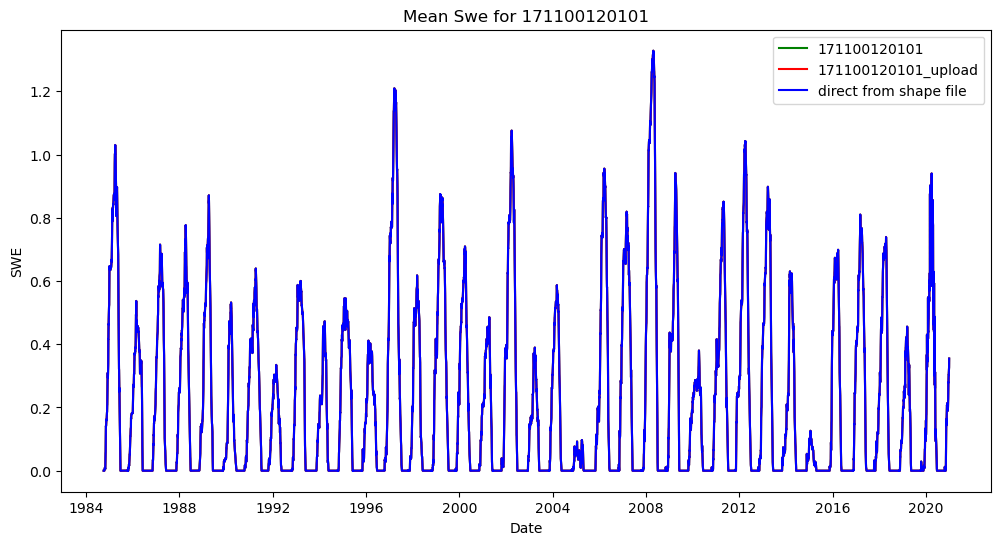

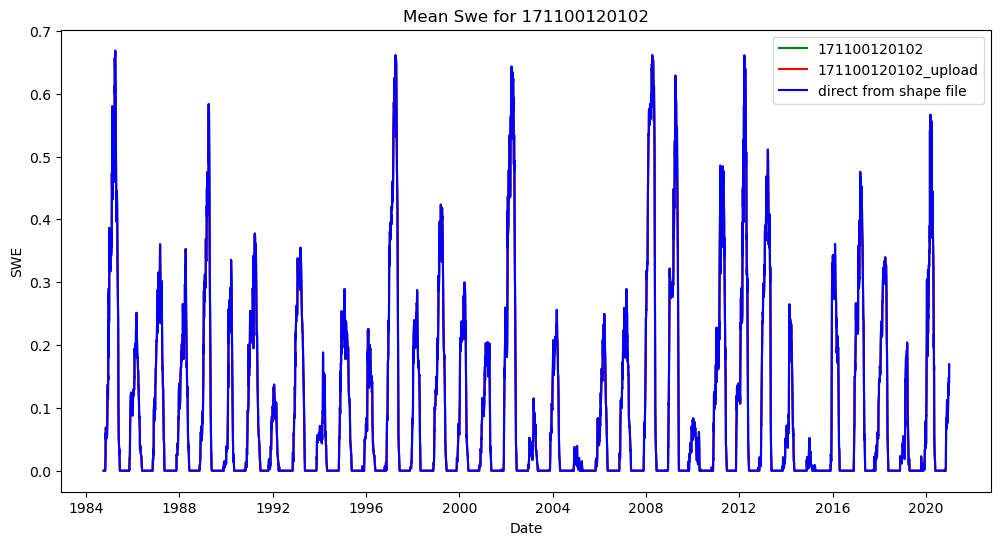

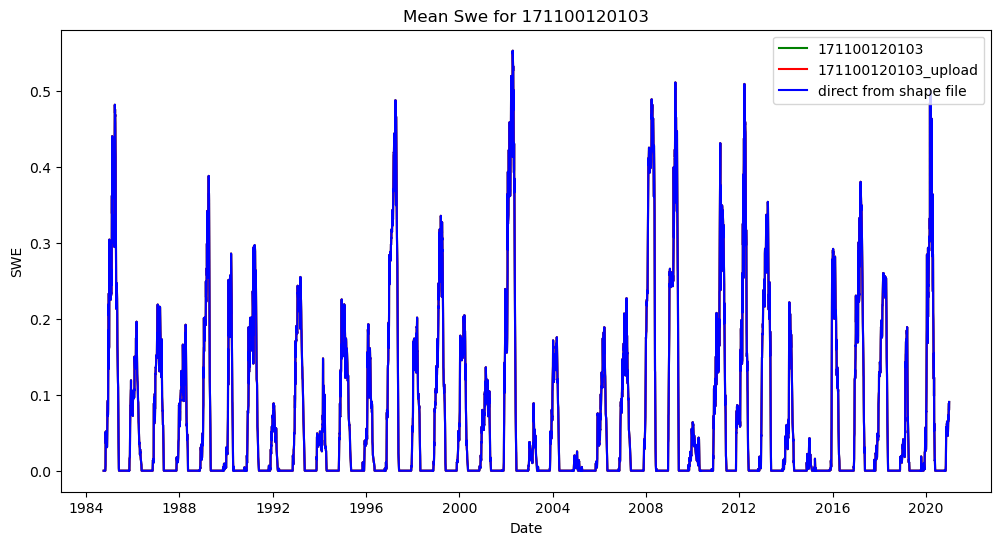

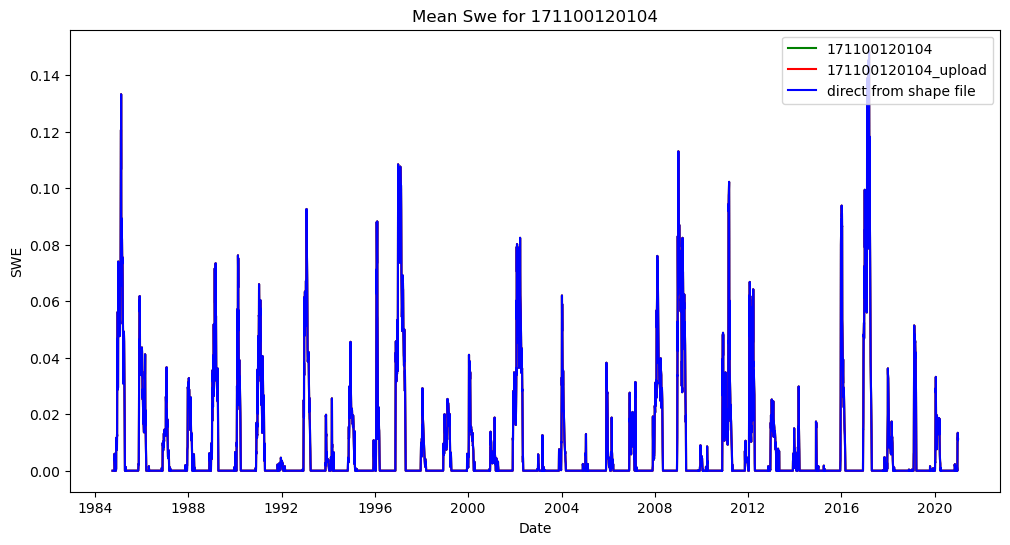

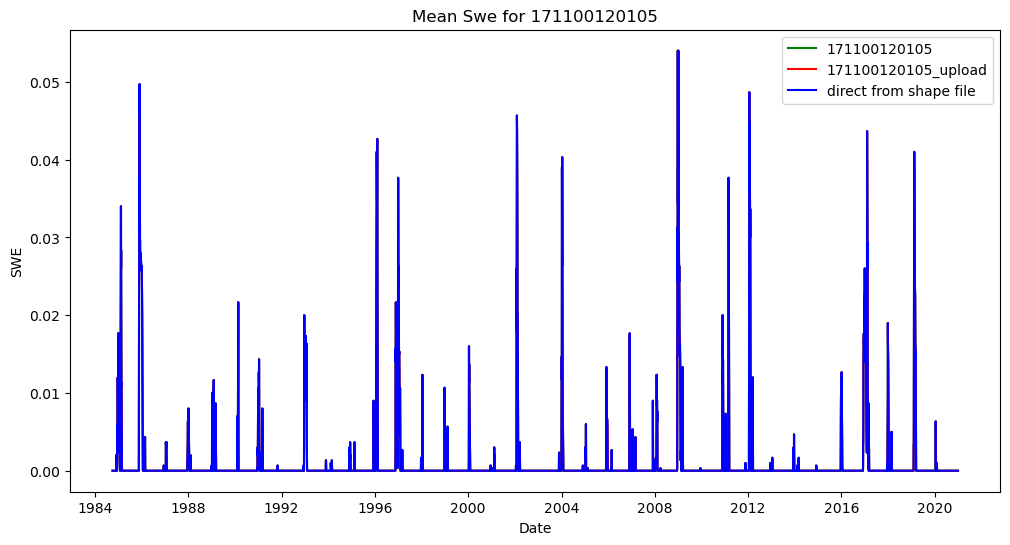

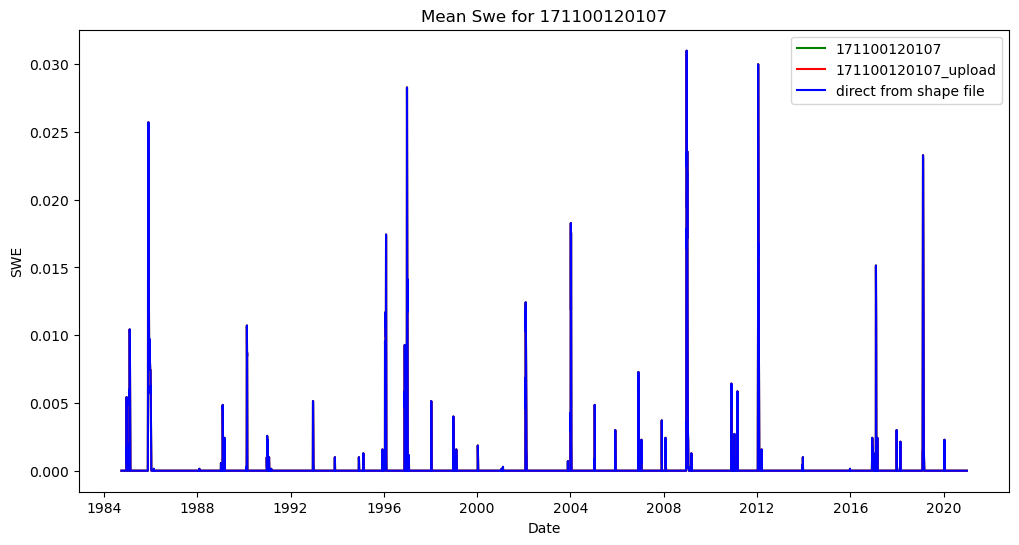

In [30]:
# plot mean Swe for each huc 
b = "snowml-gold"
for huc in huc_list: 
    df_huc, area = tot_swe_one_huc(huc)
    df_huc = filter_by_date(df_huc, BEGIN_DATE, END_DATE)
    x_vals = df_huc.index.values
    y_dict_calc = {
        "y_vals": df_huc["total_swe"]/(area*1000), 
        "color": "green",
        "label" : huc
        }
    f = f"mean_swe_in_{huc}.csv"
    df_huc2 = du.s3_to_df(f, b)
    df_huc2 = df_huc2.set_index("day")
    df_huc2 = filter_by_date(df_huc2, BEGIN_DATE, END_DATE)
    y_dict_upload = {
        "y_vals": df_huc2["mean_swe"]/1000, 
        "color": "red",
        "label": f"{huc}_upload"
    }  

    geos = gg.get_geos(huc, '12') 
    df_huc3 = mean_swe_UA_from_shape(geos)
    df_huc3 = filter_by_date(df_huc3, BEGIN_DATE, END_DATE)
    
    y_dict_shp = {
        "y_vals": df_huc3["mean_swe"]/1000,
        "color": "blue",
        "label": "direct from shape file"
    }

    
    plot(x_vals, [y_dict_calc, y_dict_upload, y_dict_shp], ttl = f"Mean Swe for {huc}")

In [31]:
huc_list

0    171100120101
1    171100120102
2    171100120103
3    171100120104
4    171100120105
5    171100120107
Name: huc_id, dtype: object